# CosmoRate

LoCPb Project 2021 - CosmoRate. 

FPGheArt - Lorenzo Buriola, Filippo Conforto, Lorenzo Domenichetti

Supervisor - Prof. Michela Mapelli, Filippo Santoloquido (PhD).

In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.transforms import offset_copy
from astropy.cosmology import Planck15 as Planck

In [20]:
#Some useful functions

def load_astro(path = "./", LBT = True ):
    data = pd.read_csv(path, delimiter = " ", skiprows=[0], header = None)
    if(LBT):
        data["LBtime"] = Planck.lookback_time(data[0]) 

    return data

def load_mass(path = r'A10/output/BBH/', binary = "BBH*"):
    all_files = glob.glob(path + binary)

    frame = pd.concat([pd.read_csv(filename, index_col=None, header=None,  skiprows=[0], delimiter = " ") for filename in all_files], axis=0, ignore_index=True)
    frame.columns = ["m1","m2","z_merg","z_form","time_delay","Z_prog"]
    
    return frame
   

    
def star_fr(z):
    return 0.01*(1+z)**2.6/(1+((1+z)/3.2)**6.2)

def grid_plot(dfs,   q1 = 0.25, q2 = 0.75, y_lo = [10,10,10], y_hi = [2000,2000,2000], LBT = True, t_list = ["BBH","BNS","BHNS"], m_list = ["A1","A5","A10"]):
    if(not LBT):
        for df in dfs:
            df["LBtime"] = Planck.lookback_time(df[0]) 
    
    fig, axes = plt.subplots(figsize = (15,15), nrows=len(t_list), ncols=len(m_list), sharex=True, sharey=False)     
    pad = 5
    
    data_list = dfs
    
    for ax, col in zip(axes[0], m_list):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='xx-large', ha='center', va='baseline')

    for ax, row in zip(axes[:,0], t_list):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='xx-large', ha='right', va='center')
        
        
    for i in range(3):
        for j in range(3):
            
            twin =  axes[i,j].twinx() 
            
            axes[i,j].plot(data_list[i+j*3].LBtime,data_list[i+j*3].iloc[:,1:-1].median(axis = 1), label=r"Model - $R$")
            axes[i,j].fill_between(data_list[i+j*3].LBtime,
                             data_list[i+j*3].iloc[:,1:-1].quantile(q1, axis = 1),
                             data_list[i+j*3].iloc[:,1:-1].quantile(q2, axis = 1),
                             alpha = 0.3,
                             facecolor = 'royalblue', label = "50% CI")
            axes[i,j].set_ylim(y_lo[i],y_hi[i])
            axes[i,j].set_yscale("log")
            twin.plot(data_list[i+j*3].LBtime, star_fr(data_list[i+j*3].iloc[:,0]),  label=r"SFR - $\Psi$", c = 'grey')
            twin.set_yscale("log")
            
            if(j == 2):
                twin.set_ylabel(r"$\Psi \,\, [M_\odot\ Mpc^{-3} yr^{-1}]$")
                axes[i,j].tick_params(  axis='y',          # changes apply to the x-axis
                                        which='both',      # both major and minor ticks are affected
                                        bottom=False,      # ticks along the bottom edge are off
                                        top=False,         # ticks along the top edge are off
                                        labelbottom=False) # labels along the bottom edge are off
                
                
            if(j == 1):
                axes[i,j].tick_params(  axis='y',          # changes apply to the x-axis
                                        which='both',      # both major and minor ticks are affected
                                        bottom=False,      # ticks along the bottom edge are off
                                        top=False,         # ticks along the top edge are off
                                        labelbottom=False) # labels along the bottom edge are off
                twin.tick_params(  axis='y',          # changes apply to the x-axis
                                        which='both',      # both major and minor ticks are affected
                                        bottom=False,      # ticks along the bottom edge are off
                                        top=False,         # ticks along the top edge are off
                                        labelbottom=False) # labels along the bottom edge are off
                
            if(j == 0):
                twin.tick_params(  axis='y',          # changes apply to the x-axis
                                        which='both',      # both major and minor ticks are affected
                                        bottom=False,      # ticks along the bottom edge are off
                                        top=False,         # ticks along the top edge are off
                                        labelbottom=False) # labels along the bottom edge are off
                
            axes[2,j].set_xlabel("Lookback Time[Yrs]")
            
            axes[i,0].set_ylabel(r'$R (z) [GPc^{-3} yr^{-1}]$')
            axes[i,j].legend(loc = 3)
            twin.legend()
            
            
    fig.tight_layout()
    fig.subplots_adjust(left=0.15, top=0.95) #, wspace=0, hspace=0)
    plt.show()
    
def multiplot(dfs,models = ["A1","A5","A10"], title = ""):
    fig,ax = plt.subplots(2,2, figsize = (10,10))
    ax = ax.flatten()
    colors = ["orange","red","blue"]
    tit= ["Mass1 distribution","Mass2 distribution","Total Mass","Delay time"]
    y_t= ["PDF"]*4
    
    x_t = ["M[Msun]","M[Msun]",r"Total mass [$M_{sun}$]","Time Delay [yr]"]

    logbins_mass=np.logspace(start=np.log10(1), stop=np.log10(1000), num=50)
    logbins_time=np.logspace(start=np.log10(5066000), stop=np.log10(13351830100), num=50)
    for df,color in zip(dfs,colors):
        ax[0].hist(df[['m1','m2']].max(axis=1), bins = logbins_mass, alpha = 1, lw = 2, color= color,histtype = 'step', density = True)
        ax[1].hist(df[['m1','m2']].min(axis=1), bins = logbins_mass, alpha = 1, lw = 2, color= color,histtype = 'step', density = True)
        ax[2].hist(df.m1+df.m2, bins = logbins_mass, alpha = 1, lw = 2, color= color,histtype = 'step',density = True )
        ax[3].hist(df.time_delay, bins = logbins_time, alpha = 1, lw = 2, color= color,histtype = 'step', density = True)
    for i in range(0,4):
        ax[i].set_title(tit[i])
        ax[i].set_xlabel(x_t[i])
        ax[i].set_ylabel(y_t[i])
        ax[i].set_yscale("log")
        ax[i].set_xscale("log")
        ax[i].legend(models)
    plt.suptitle(title)
    plt.tight_layout(h_pad=3)
    plt.show()
    
def t_plot(df,zs,binn, ax):
    logbins_time=np.logspace(start=np.log10(5066000), stop=np.log10(13351830100), num=50)
    colors = ["orange","red","blue","black","yellow"]
    for z,color in zip(zs,colors):
        ax.hist(df[(df["z_merg"] > z-binn) & (df["z_merg"] < z+binn) ].time_delay, bins = logbins_time,  color= color,histtype = 'step', density = True, lw =2, label = f"z={z}")
        ax.axvline(Planck.lookback_time(z).value*10**9)
    ax.legend()
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("Time Delay(yr)")
    ax.set_ylabel("PDF")
    

def plot_h_2d(list_df, list_ax, list_df_weights, list_title,  m_list = ["A1","A5","A10"], t_list = ["BBH","BNS","BHNS"]):
    
    pad = 5
    for ax, col in zip(axes[0], m_list):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='xx-large', ha='center', va='baseline')

    for ax, row in zip(axes[:,0], t_list):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='xx-large', ha='right', va='center')
        
    for df, ax, df_w in zip(list_df, list_ax.flatten(), list_df_weights):

        bin_num = df_w[df_w.iloc[:,1]!=0].iloc[:,1].shape[0]
        H, xedges, yedges = np.histogram2d(df.m1+df.m2, df.z_merg, bins = bin_num)

        ax.imshow(np.multiply(H.T, np.repeat(np.array(df_w[df_w.iloc[:,1]!=0].iloc[:,1]), bin_num).reshape(bin_num,bin_num)), 
                  interpolation='nearest', origin='lower',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
                  aspect='auto')

    fig.tight_layout(h_pad = 3)
    fig.subplots_adjust(left=0.15, top=0.95)
    plt.show()


## Week1

Run cosmoRate for the three different astrophysical models - "A1", "A5", "A10".

• Turn ON the option to evaluate the uncertainty and to create the catalogs of merging compact objects

• Plot of the MRD with uncertainty (median and 25% and 75% percentile). You should get something very similar to this figure

<div>
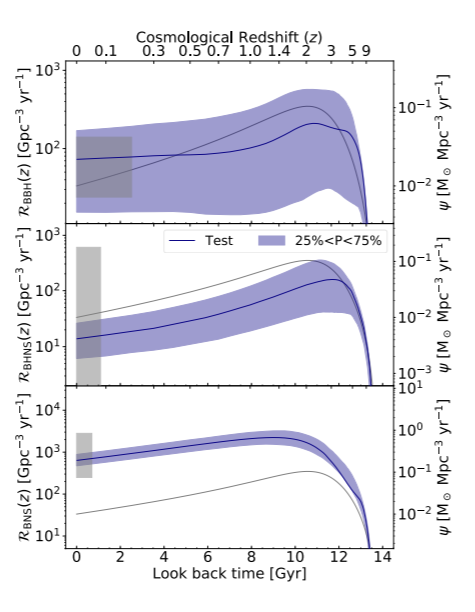
</div>
<!-- 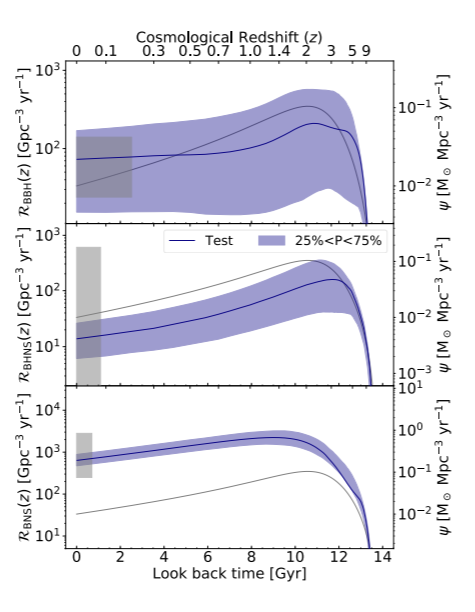 -->



Parliamo ora dei plot che contengono anche l'incertezza.. 






In [3]:
data_BBH_A1 = load_astro("A1/output/BBH/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BHNS_A1 = load_astro("A1/output/BHNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BNS_A1 = load_astro("A1/output/BNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")

data_BBH_A5 = load_astro("A5/output/BBH/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BHNS_A5 = load_astro("A5/output/BHNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BNS_A5 = load_astro("A5/output/BNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")

data_BBH_A10 = load_astro("A10/output/BBH/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BHNS_A10 = load_astro("A10/output/BHNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")
data_BNS_A10 = load_astro("A10/output/BNS/MRD_spread_12Z_50_No_D18solmet_0.2_Yes_Yes_0.dat")

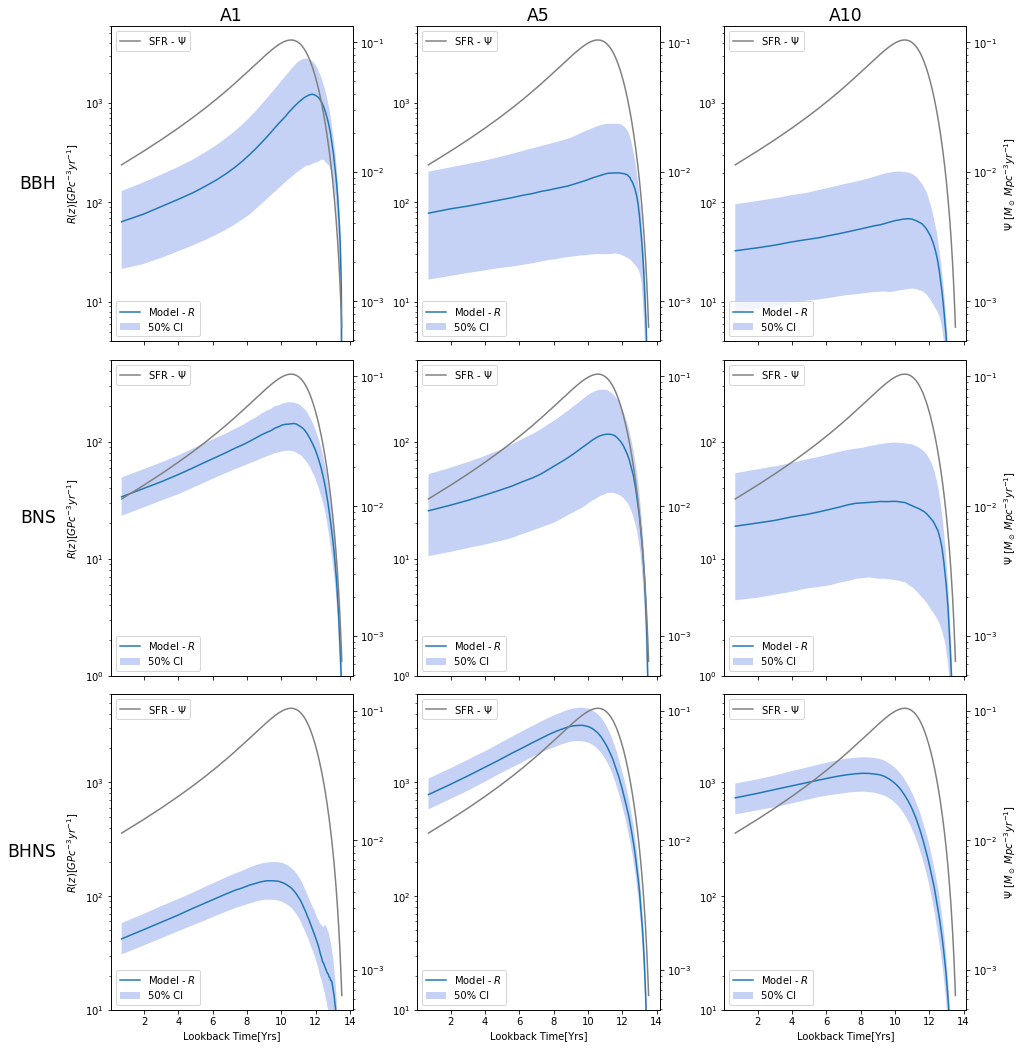

In [21]:
grid_plot([data_BBH_A1, data_BHNS_A1, data_BNS_A1,
            data_BBH_A5, data_BHNS_A5, data_BNS_A5,
            data_BBH_A10, data_BHNS_A10, data_BNS_A10,],  y_hi = [6000,500,6000], y_lo = [4,1,10])

• Plot the distribution of delay times and the distribution of masses


For some coincidences we have run cosmo_rate with a different N_catalog parameter. The highest one was A10, with 10000 catalogues. The results are not complete due to (maybe) lack of statistics. 

<!-- We have produces a single plot not distinguishing the various Redshifts - this was due to the fact that choosing a particular z did not leato a  sufficient amount of data.
 -->
 
 

• Make a 2D histogram as a function of mass and redshift

In [5]:
cat_BBH_A1 = load_mass(r'A1/output/BBH/', "BBH*")

cat_BBH_A5 = load_mass(r'A5/output/BBH/', "BBH*")

cat_BBH_A10 = load_mass(r'A10/output/BBH/', "BBH*")


cat_BNS_A1 = load_mass(r'A1/output/BNS/', "BNS*")

cat_BNS_A5 = load_mass(r'A5/output/BNS/', "BNS*")

cat_BNS_A10 = load_mass(r'A10/output/BNS/', "BNS*")


cat_BHNS_A1 = load_mass(r'A1/output/BHNS/', "BHNS*")

cat_BHNS_A5 = load_mass(r'A5/output/BHNS/', "BHNS*")

cat_BHNS_A10 = load_mass(r'A10/output/BHNS/', "BHNS*")

cat_BBH_A5_det = load_mass(r'A5/output_noin/BBH/', "BBH*")

cat_BBH_A1_det = load_mass(r'A1/output_noin/BBH/', "BBH*")


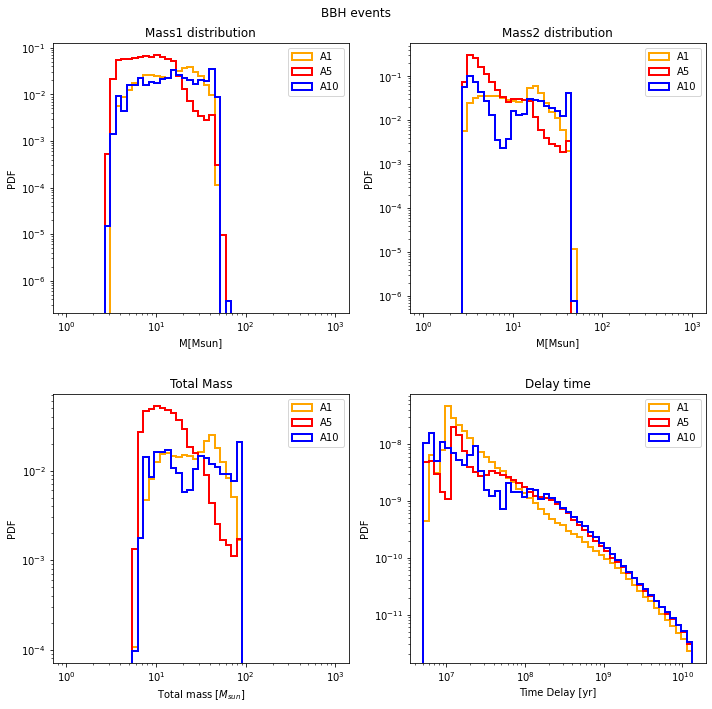

In [6]:
multiplot([cat_BBH_A1, cat_BBH_A5, cat_BBH_A10],title = "BBH events")

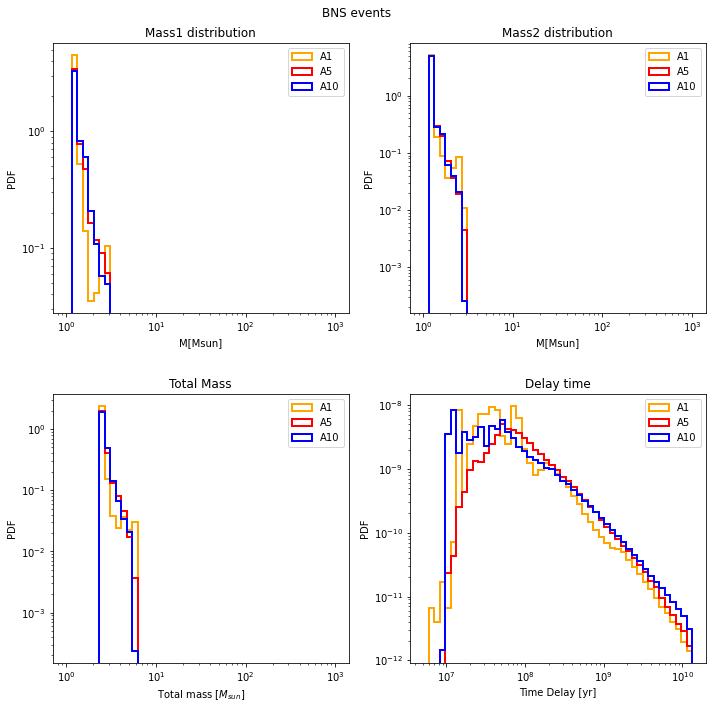

In [7]:
multiplot([cat_BNS_A1, cat_BNS_A5, cat_BNS_A10],title = "BNS events")

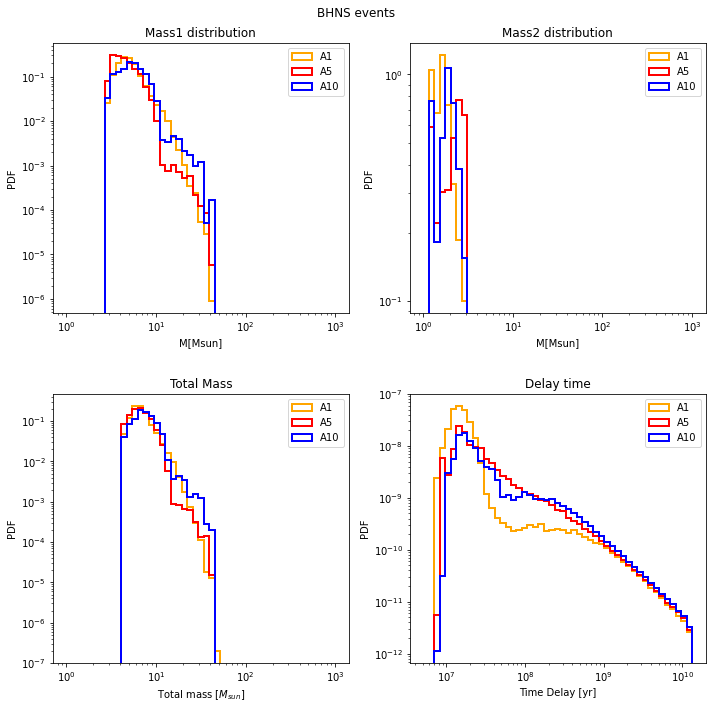

In [8]:
multiplot([cat_BHNS_A1, cat_BHNS_A5, cat_BHNS_A10], title = "BHNS events")

In [10]:
def t_plot(df,zs,binn, ax):
    logbins_time=np.logspace(start=np.log10(5066000), stop=np.log10(13351830100), num=50)
    colors = ["orange","red","blue","black","yellow"]
    for z,color in zip(zs,colors):
        ax.hist(df[(df["z_merg"] > z-binn) & (df["z_merg"] < z+binn) ].time_delay, bins = logbins_time,  color= color,histtype = 'step', density = True, lw =2, label = f"z={z}")
        ax.axvline(Planck.age(0).value*10**9 - Planck.lookback_time(z).value*10**9, color = color)
    ax.legend()
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("Time Delay(yr)")
    ax.set_ylabel("PDF")

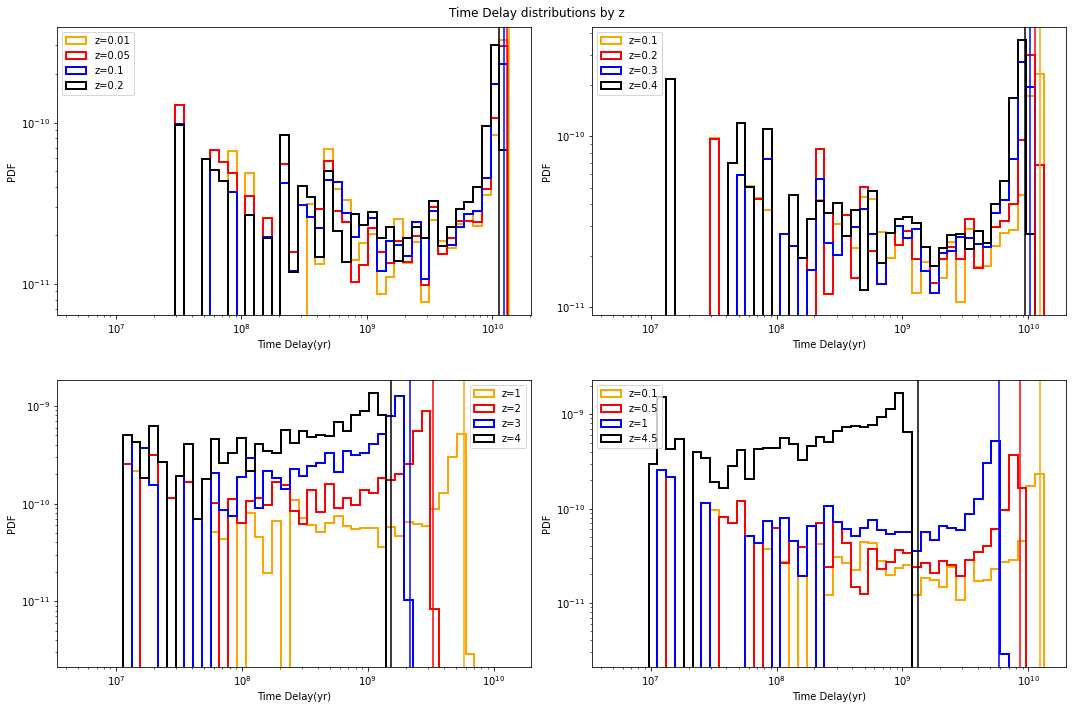

In [11]:
fig, ax = plt.subplots(2,2, figsize =(15,10))
ax = ax.flatten()
t_plot(cat_BBH_A5,[0.01,0.05,0.1,0.2],0.1,ax[0])
t_plot(cat_BBH_A5,[0.1,0.2,0.3,0.4],0.1,ax[1])
t_plot(cat_BBH_A5,[1,2,3,4],0.1,ax[2])
t_plot(cat_BBH_A5,[0.1,0.5,1,4.5],0.1,ax[3])

plt.suptitle("Time Delay distributions by z")
plt.tight_layout(h_pad=3)

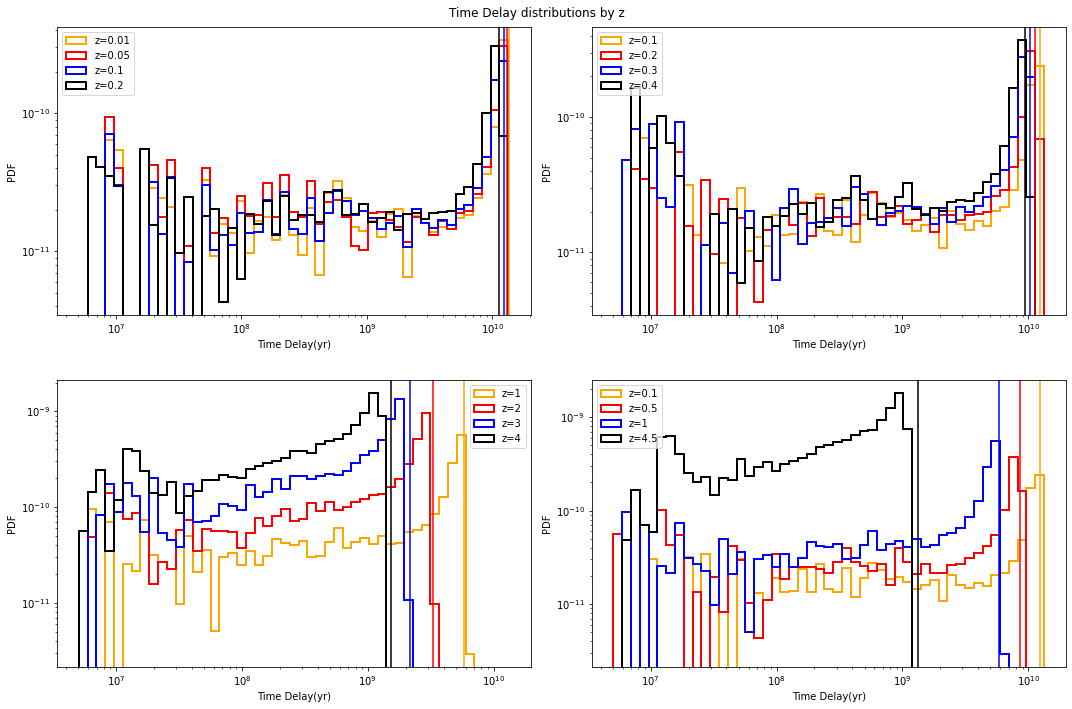

In [12]:
fig, ax = plt.subplots(2,2, figsize =(15,10))
ax = ax.flatten()
t_plot(cat_BBH_A5_det,[0.01,0.05,0.1,0.2],0.1,ax[0])
t_plot(cat_BBH_A5_det,[0.1,0.2,0.3,0.4],0.1,ax[1])
t_plot(cat_BBH_A5_det,[1,2,3,4],0.1,ax[2])
t_plot(cat_BBH_A5_det,[0.1,0.5,1,4.5],0.1,ax[3])


plt.suptitle("Time Delay distributions by z")
plt.tight_layout(h_pad=3)

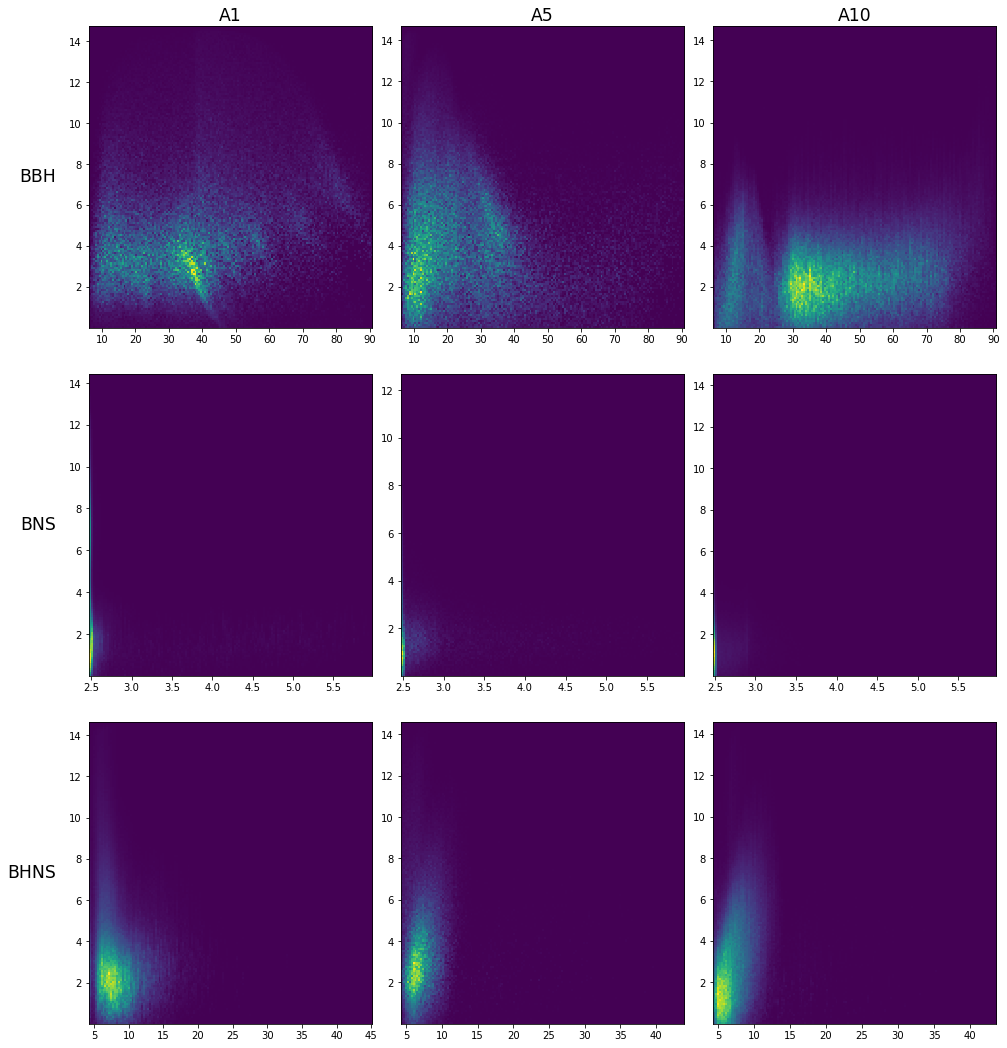

In [15]:
fig, axes = plt.subplots(3,3, figsize = (15,15))

list_cat = [cat_BBH_A1,  cat_BBH_A5,  cat_BBH_A10,  cat_BNS_A1,  cat_BNS_A5,  cat_BNS_A10, cat_BHNS_A1,   cat_BHNS_A5,  cat_BHNS_A10]
list_mrd = [data_BBH_A1, data_BBH_A5, data_BBH_A10, data_BNS_A1, data_BNS_A5, data_BNS_A10, data_BHNS_A1, data_BHNS_A5, data_BHNS_A10]
    
plot_h_2dudo(list_cat, axes, list_mrd, titles)